In [1]:
import pandas as pd
import networkx as nx
import markov_clustering as mc
import numpy as np
import os
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


In [2]:
class task_2_1_a:
    def __init__(self):
        self.union_df = pd.read_csv('results/task_1_3_union.csv', index_col=0, sep=';')
        self.sgi_df = pd.read_csv('results/task_1_3_sgi.csv', index_col=0)
        self.intersection_df = pd.read_csv('results/task_1_3_intersection.csv', index_col=0)
        
        self.r_partial_union = pd.read_csv('data/task_2_1_a_partial_union.csv', index_col=0).T
        self.r_partial_sgi = pd.read_csv('data/task_2_1_a_partial_sgi.csv').T.drop('Unnamed: 0')
        self.r_partial_intersection = pd.read_csv('data/task_2_1_a_partial_intersection.csv').T.drop('Unnamed: 0')
    
    def adj_matrix_on_csv(self):
        u_graph = nx.from_pandas_edgelist(self.union_df, source = 'interactor A gene symbol', target='interactor B gene symbol')
        i_graph = nx.from_pandas_edgelist(self.intersection_df, source = 'interactor A gene symbol', target='interactor B gene symbol')
        s_graph = nx.from_pandas_edgelist(self.sgi_df, source = 'interactor A gene symbol', target='interactor B gene symbol')

        # save adjacency matrix for more computations on R with igraph package (faster)
        a_u= nx.to_numpy_matrix(u_graph)
        a_i= nx.to_numpy_matrix(i_graph)
        a_s= nx.to_numpy_matrix(s_graph)
        try:
            os.remove('data/task_2_1_%s'%'union' +'_adj_matrix.csv')
            os.remove('data/task_2_1_%s'%'intersection' +'_adj_matrix.csv')
            os.remove('data/task_2_1_%s'%'sgi' +'_adj_matrix.csv')
        except:
            pass
        # save to csv
        pd.DataFrame(a_u).to_csv('data/task_2_1_%s'%'union' +'_adj_matrix.csv')
        pd.DataFrame(a_i).to_csv('data/task_2_1_%s'%'intersection' +'_adj_matrix.csv')
        pd.DataFrame(a_s).to_csv('data/task_2_1_%s'%'sgi' +'_adj_matrix.csv')
        
    @staticmethod
    def global_measures(df, type_net):
        '''
        Inputs:
        
            - df = dataframe of interactions;
            
            - type_net = string which represents the interactome type (union, intersection or sgi).
            
        Returns:
            IF graph with more than 20 nodes:
                - result df = dataframe with partial results for the input graph:
                    - if intersection and sgi graphs (more connected components): centralization measure is missing beacuse computed on R; 
                    
                    - if union graph (one connected component): centralization, avg sp, diameter and radius are missing becuase computed on R:
                        igraph package on R has better computational performances for high dimensional graphs);

            ELSE:
                - print string.
        '''
        result_dict = {}
        # undirected graph object
        graph = nx.from_pandas_edgelist(df, source = 'interactor A gene symbol', target='interactor B gene symbol')
        # check number of nodes
        if graph.number_of_nodes() >20:
            n_nodes = graph.number_of_nodes()
            # not consider the duplicates (union can have same edges with different sources: they will be considered just one time)
            n_edges = graph.number_of_edges()
            # number of connected components
            conn_components = nx.number_connected_components(graph)
            # number of isolates
            n_isolates = nx.number_of_isolates(graph)
            # average degree
            #avg_degree = n_edges/n_nodes
            degrees = dict(graph.degree())
            sum_of_edges = sum(degrees.values())
            avg_degree = sum_of_edges/n_nodes
            # avg clustering coefficient
            avg_cluster_coeff = nx.average_clustering(graph)
            # building dictionary of results for th whole graph 
            result_dict['Nodes'] = [n_nodes]
            result_dict['Edges'] = [n_edges]
            result_dict['Connected Components'] = [conn_components]
            result_dict['Isolates'] = [n_isolates]
            result_dict['Avg Degree'] = [avg_degree]
            result_dict['Avg Cluster Coeff'] = [avg_cluster_coeff]
            

            # list of col names
            ll=['Graph']
            # save adjacency matrix for more computations on R with igraph package (faster)
            a= nx.to_numpy_matrix(graph)
            try:
                os.remove('data/task_2_1_%s'%type_net +'_adj_matrix.csv')
            except:
                pass
            # save to csv
            pd.DataFrame(a).to_csv('data/task_2_1_%s'%type_net +'_adj_matrix.csv')

            # if graph not connected  (i.e. if more than one connected component)
            if conn_components !=1:
                result_dict['Avg Shortest Path'] = ['-']
                result_dict['Diameter'] = ['-']
                result_dict['Radius'] = ['-']
                # counter
                c = 1
                #for each connected component computes the properties
                for g in nx.connected_component_subgraphs(graph): 
                    # update dictionary of results
                    result_dict['Nodes'].append(nx.number_of_nodes(g))
                    result_dict['Edges'].append(nx.number_of_edges(g))
                    result_dict['Avg Shortest Path'].append(nx.average_shortest_path_length(g))
                    result_dict['Diameter'].append(nx.diameter(g))
                    result_dict['Radius'].append(nx.radius(g))
                    result_dict['Avg Degree'].append('-')
                    result_dict['Avg Cluster Coeff'].append('-')
                    result_dict['Isolates'].append('-')
                    result_dict['Connected Components'].append('-')
                    # update list of cols names
                    ll.append('Connected Component %d'%c)
                    # update counter
                    c +=1
            # from dictionary to df
            result_df = pd.DataFrame.from_dict(result_dict, orient = 'index', columns=ll)
            # return df
            return result_df
        # if n nodes <= 20, then stop
        else:

            print('%s'%type_net,'network do not have a number of edges bigger than 20')
            
            
    @staticmethod
    def final_sgi_inters(partial, r_partial):
        r_partial.rename(columns={0:'Graph'}, inplace = True)
        ll = ['-' for x in range(len(partial.columns[1:]))]
        na_df = pd.DataFrame([ll,ll,ll], columns = partial.columns[1:], index=['Btw Centralization', 'Degree Centralization', 'Eigen Centralization'])
        r_partial = pd.concat([r_partial,na_df],axis=1)
        final_df = pd.concat([partial,r_partial])
        return final_df
    
    def compute_global_measures(self):
        partial_union = task_2_1_a.global_measures(self.union_df, 'union')
        partial_sgi = task_2_1_a.global_measures(self.sgi_df, 'sgi')
        partial_intersection = task_2_1_a.global_measures(self.intersection_df, 'intersection')
        
        
        self.r_partial_union.rename(columns={1:'Graph'}, inplace = True)
        final_union_df = pd.concat([partial_union, self.r_partial_union])
        
        
        final_sgi_df = task_2_1_a.final_sgi_inters(partial_sgi, self.r_partial_sgi)
        final_intersection_df = task_2_1_a.final_sgi_inters(partial_intersection,self.r_partial_intersection)
        return final_union_df,final_sgi_df, final_intersection_df
    
    def save_results(self):
        union_df, sgi_df, intersection_df = self.compute_global_measures()
        try:
            os.remove('results/task_2_1_union.csv')
            os.remove('results/task_2_1_sgi.csv')
            os.remove('results/task_2_1_intersection.csv')
        except:
            pass
        
        union_df.to_csv('results/task_2_1_union.csv')
        sgi_df.to_csv('results/task_2_1_sgi.csv')
        intersection_df.to_csv('results/task_2_1_intersection.csv')
        
    def plot_sgi(self):
        sgi_graph =nx.from_pandas_edgelist(self.sgi_df, source = 'interactor A gene symbol', target='interactor B gene symbol')
        figure(figsize=(10,10)) 
        plt.title("SGI Network")
        nx.draw_networkx(sgi_graph, node_color = 'red',with_labels=False, node_color_size= 200)
        plt.show()

In [3]:
### TASK 2.1 A
task_A = task_2_1_a()
# save adj matrix on csv
task_A.adj_matrix_on_csv()

### run task 2_1_a.R

In [4]:
# save results
task_A.save_results()
print('TASK 2.1.A \n Results saved')

TASK 2.1.A 
 Results saved


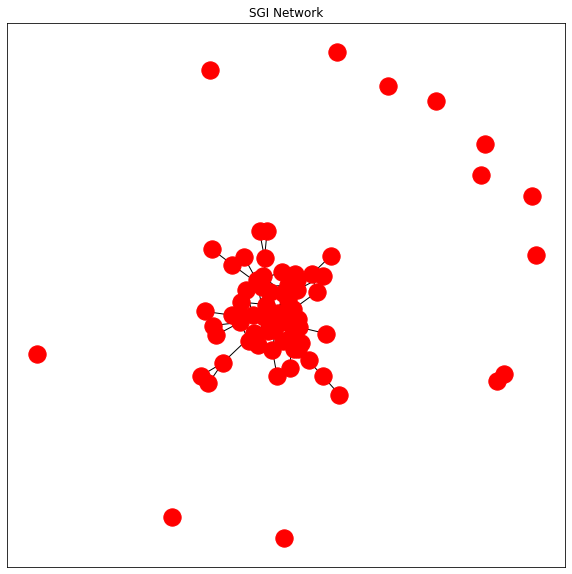

In [5]:
task_A.plot_sgi()

In [6]:
'''
class LCC

Save to csv the adjacency matrix in order to use it on R.

Compute global and local measures of the largest connected component 
    of the graph corresponding to the given df.
'''

class LCC(object):
    def __init__(self, dataframe, data_type):
        '''
        - dataframe: dataset corresponding to the union or the intersection
        
        - data_type: string to indicate type of df ('union' or 'intersection')
        '''
        
        self.df = dataframe
        self.data_type = data_type
    
    def lcc_graph(self):
        '''
        Returns:
        
            - largest connected component graph
        '''
        # create graph from df
        graph = nx.from_pandas_edgelist(self.df, source = 'interactor A gene symbol', target='interactor B gene symbol')
        conn_components = nx.number_connected_components(graph)
        if conn_components ==1:
            return graph
        else:
            # return set of nodes of the largest connected component
            lcc_set = max(nx.connected_components(graph), key=len)
            # lcc subgraph
            lcc_graph = graph.subgraph(lcc_set)
            return lcc_graph
        
    def plot_lcc(self):
        lcc_graph =self.lcc_graph()
        figure(figsize=(10,10)) 
        plt.title("I-LCC Network")
        nx.draw_networkx(lcc_graph, node_color = 'cyan',with_labels=False, node_color_size= 200)
        plt.show()

    def lcc_a_matrix_to_csv(self):
        '''
        Returns:
        
            - file .csv with the adjacency matrix of the graph corresponding 
                to the df given in input to the class. 
        
        It is necessary saving the matrix on an external file in order to use it for more 
            computations in R, where specific functions are faster.
        '''
    
        # lcc subgraph
        lcc_graph = self.lcc_graph()
        # numpy adj matrix
        a= nx.to_numpy_matrix(lcc_graph)
        try:
            os.remove('data/task_2_1_%s'%self.data_type +'_lcc_matrix.csv')
        except:
            pass
        # save to csv
        #np.savetxt('data/%s'%data_type+'_lcc_matrix.csv', a, delimiter=",", header='')
        pd.DataFrame(a).to_csv('data/task_2_1_%s'%self.data_type +'_lcc_matrix.csv')

    def task_2_1_b_global(self):
        '''
        Returns:
        
            - df: dataframe of global measures for the graph which corresponds to the 
                input dataframe (union or inters).
            
            - nodes: list of nodes names of the graph.
        '''
        # lcc subgraph
        lcc_graph = self.lcc_graph()
        # number of nodes
        n_nodes = lcc_graph.number_of_nodes()
        # number of edges
        # not consider the duplicates (union can have same edges with different sources: they will be considered just one time)
        n_edges = lcc_graph.number_of_edges()
        # average degree
        degrees = dict(lcc_graph.degree())
        sum_of_edges = sum(degrees.values())
        avg_degree = sum_of_edges/n_nodes
        # avg clustering coefficient
        avg_cluster_coeff = nx.average_clustering(lcc_graph)
        # create df
        df = pd.DataFrame([n_nodes, n_edges, avg_degree, avg_cluster_coeff])
        df.rename({0:'Nodes', 1:'Edges', 2:'Avg Degree', 3:'Avg Clustering Coeff'}, inplace = True)
        # lcc nodes
        nodes = list(lcc_graph.nodes())
        return df, nodes

    def merge_global_measures(self):
        '''
        Return:
        
            - dataframe containing the global measures of the graph computed on Python and R.
                In particular there are: number of edges and nodes, avg degree, avg clustering coefficient, 
                    avg. path length, diameter and radius. 
        
        '''
        # compute the above function to obtain global measures
        lcc_global1, lcc_nodes  = self.task_2_1_b_global()
        # upload the df containg avg shortest path, diameter and radius
        # it was computed on R because of the better computational time of the functions
        lcc_global2 = pd.read_csv('data/task_2_1_%s'%self.data_type+'_lcc_global_results.csv')
        # concatenate the 2 dataframe in one
        lcc_global = pd.concat([lcc_global1.T, lcc_global2], axis = 1).drop(['Unnamed: 0'], axis=1)
        lcc_global = lcc_global.rename({0:'lcc_%s'%self.data_type}) 
        
        return lcc_global
    
    
    def save_local_results(self):
        '''
        Returns:
        
            - file .csv with the local measures related to the graph of the input df (union or intersection)
        '''
        # lcc nodes names
        _,lcc_nodes = self.task_2_1_b_global()
        # load local dfs computed on R because of the better computational time
        lcc_local = pd.read_csv('data/task_2_1_%s'%self.data_type +'_lcc_local_results.csv').drop('Unnamed: 0', axis=1)
        # rename rows with gene names
        lcc_local = lcc_local.rename(dict(zip([x for x in range(len(lcc_local))],lcc_nodes)))
        # save local df results
        try:
            os.remove('results/task_2_1_%s'%self.data_type +'_lcc_local.csv')
        except:
            pass

        
        lcc_local.to_csv('results/task_2_1_%s'%self.data_type +'_lcc_local.csv')
     
    def btw_first_20(self):
        '''
        Returns:
        
            - file csv with df of centrality measure for the first 20 nodes based on btw centrality value.
        '''
        
        
        local_df = pd.read_csv('results/task_2_1_%s'%self.data_type +'_lcc_local.csv')
        _,lcc_nodes = self.task_2_1_b_global()
        local_df.sort_values(by=['Betweenness Centrality'], inplace = True,ascending=False)
        local_df=local_df[:20]
        local_df = local_df[['Betweenness Centrality', 'Eigen Centrality', 'Closeness Centrality']]
        my_nodes = [lcc_nodes[i] for i in list(local_df.index)]
        local_df.rename(dict(zip(list(local_df.index), my_nodes)), inplace=True)
        try:
            os.remove('results/task_2_1_%s'%self.data_type+'_btw_first20.csv')
        except:
            pass
                        
        local_df.to_csv('results/task_2_1_%s'%self.data_type+'_btw_first20.csv')
        
    def mcl_algo(self):
        '''
        Returns:
            
            - Scipy sparse adjacency matrix.
            - List of clusters: each cluster is a sublist containing the nodes which belongs to it.
            
        '''
        graph = self.lcc_graph()
        adj_matrix = nx.to_scipy_sparse_matrix(graph)
        ### !!! attention: it works only with scipy version 1.2.0 !!!
        result = mc.run_mcl(adj_matrix)           # run MCL with default parameters
        clusters = mc.get_clusters(result)  # get clusters
        return adj_matrix,clusters
    
    
    def mcl_plot():
        adj_matrix, clusters = self.mcl_algo()
        mc.draw_graph(adj_matrix, clusters, node_size=50, with_labels=False, edge_color="silver")
        
        
    def hypergeometric_test(self):
        '''
        Returns:
        
            - Dictionary where for each cluster id gives the corresponding p-value.
        '''
        # list of sublists: each i-sublist contains nodes belogning to i-cluster
        _ , lcc_clusters = self.mcl_algo()
        # list of lcc nodes names
        _, lcc_nodes = self.task_2_1_b_global()
        # list of seeds genes
        seed_genes = list(pd.read_csv('data/task_1_4_seed_genes.txt', header=None)[0])
        # seeds in lcc
        seeds_lcc = [x for x in seed_genes if x in lcc_nodes]
        # population M = number of genes in lcc
        pop = len(lcc_nodes)
        #initialize p-values dictionary
        p_values = {}
        # cluster index
        c = 0
        for cluster in lcc_clusters:
            # n nodes in cluster
            cluster_dimension = len(cluster)
            # check number of nodes
            if cluster_dimension >= 10:
                # list of seed genes in cluster
                seeds_in_cluster = [lcc_nodes[x] for x in cluster if lcc_nodes[x] in seeds_lcc]
                # number of seeds in cluster
                # genes in cluster
                genes_in_cluster = [lcc_nodes[x] for x in cluster]
                # number of seeds in cluster
                n_seeds_in_cluster = len(seeds_in_cluster)
                # parameter for hypergeom test
                M,n,N,x =  pop, cluster_dimension,len(seeds_lcc),n_seeds_in_cluster
                pval = hypergeom.sf(x-1, M, n, N)
                
                p_values[c] = [pval]
                p_values[c].append('MCL')
                p_values[c].append(n_seeds_in_cluster)
                p_values[c].append(cluster_dimension)
                p_values[c].append(','.join(seeds_in_cluster))
                p_values[c].append(','.join(genes_in_cluster))
                
            c+=1
        # putatitive diseases modules dictionary
        pdm_dic = {}
        for i in p_values.keys():

            if p_values[i][0] < 0.05:
                pdm_dic[i] = p_values[i]

        return pdm_dic
    
    def save_test_results(self):

        pdm_lcc = self.hypergeometric_test()
        lcc_clust_results = pd.DataFrame.from_dict(pdm_lcc).T
        new_col_names = ['p-value','Clustering Algorithm', 'Seed Genes Number', 'Total Genes Number', 'Seed Genes ID', 'Genes ID']
        lcc_clust_results.rename(columns = dict(zip([x for x in range(len(new_col_names))], new_col_names)), inplace=True)
        lcc_clust_results.rename_axis('Cluster ID',inplace=True)
        try: 
            os.remove('results/task_2_2_lcc_%s'%self.data_type +'_putative_disease_modules.csv')
        except:
            pass

        lcc_clust_results.to_csv('results/task_2_2_lcc_%s'%self.data_type +'_putative_disease_modules.csv')

    

In [7]:
union_df = pd.read_csv('results/task_1_3_union.csv', index_col=0, sep=';')
intersection_df = pd.read_csv('results/task_1_3_intersection.csv', index_col=0)
# call the class for the 2 dataframes
LCC_union = LCC(union_df, 'union')
LCC_inters = LCC(intersection_df, 'intersection')


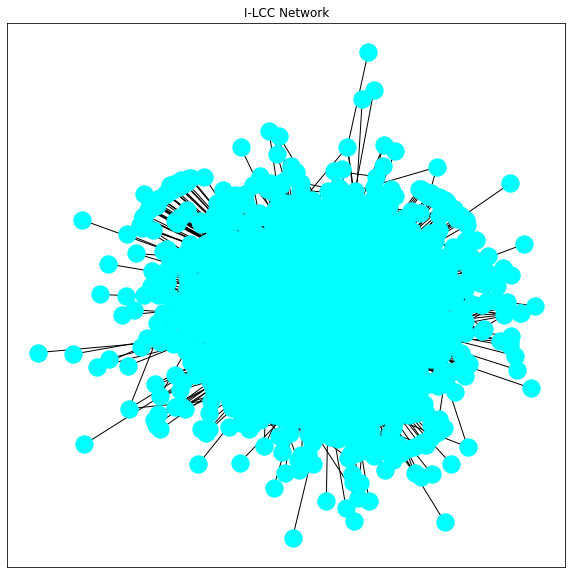

In [8]:
LCC_inters.plot_lcc()

In [9]:
# saving on csv first 20 nodes by btw centrality values for both lcc
LCC_inters.btw_first_20()
LCC_union.btw_first_20()

In [10]:
# save adjacency matrix for the 2 graphs in order to use it on R
LCC_union.lcc_a_matrix_to_csv()
LCC_inters.lcc_a_matrix_to_csv()
### run task_2_1_b.r

In [11]:
### TASK 2.1 B - GLOBAL
# union global measures df 
lcc_union_global = LCC_union.merge_global_measures()
# intersection global measures df 
lcc_inters_global = LCC_inters.merge_global_measures()
# concatenate the 2 final dataframes
lcc_global = pd.concat([lcc_union_global, lcc_inters_global], axis = 0)
# save resulting df on csv
# remove if already existing adn then create the new one
try:
    os.remove('results/task_2_1_lcc_global.csv')
except: 
    pass
lcc_global.to_csv('results/task_2_1_lcc_global.csv')


In [12]:
### TASK 2.1 B - LOCAL

# save lcc union local results
LCC_union.save_local_results()
# save lcc intersection local results
LCC_inters.save_local_results()

In [13]:
### TASK 2.2
pdm_lcc_union = LCC_union.save_test_results()
pdm_lcc_inters = LCC_inters.save_test_results()